In [190]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')
import numpy as np

In [191]:
data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
                ,now() as now
            from f
            --where time < toStartOfFifteenMinutes(now())
            --toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            --where FifteenMinutes > today() -1
            --where FifteenMinutes <= '2022-06-07 11:15:00'
            order by FifteenMinutes
            '''
            ).df 
data_from_base.tail(4)

,FifteenMinutes,date,hm,dau_news,view,like,CTR,dau_message,count_message,now
6978,2022-06-08 16:30:00,2022-06-08,16:30,692,10665,2339,0.219316,143,200,2022-06-08 17:30:59
6979,2022-06-08 16:45:00,2022-06-08,16:45,682,10302,2341,0.227237,144,183,2022-06-08 17:30:59
6980,2022-06-08 17:00:00,2022-06-08,17:00,717,11027,2366,0.214564,138,182,2022-06-08 17:30:59
6981,2022-06-08 17:15:00,2022-06-08,17:15,728,11374,2381,0.209337,131,174,2022-06-08 17:30:59


In [192]:
voc = pd.DataFrame(
       [['dau_news','http://superset.lab.karpov.courses/r/1241', 'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['view','http://superset.lab.karpov.courses/r/1243',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['like','http://superset.lab.karpov.courses/r/1242',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['CTR','http://superset.lab.karpov.courses/r/1244',  'https://superset.lab.karpov.courses/superset/dashboard/988/',4,3,5,0.1], 
       ['dau_message','http://superset.lab.karpov.courses/r/1245',  'https://superset.lab.karpov.courses/superset/dashboard/988/',1.5,3,5,0.1], 
       ['count_message','http://superset.lab.karpov.courses/r/1246',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,3,7,0.1]]\
        , columns=['index','Chart_url','Dash_url','a1','a2','n','thereshold'])

In [193]:
    # межквартильный размах
    metric = 'count_message'
    voc_new = voc[voc['index'] == metric]
    chart = voc_new['Chart_url'].iloc[-1]
    dash = voc_new['Dash_url'].iloc[-1]
    a1 = voc_new['a1'].iloc[-1]
    a2 = voc_new['a2'].iloc[-1]        
    n = voc_new['n'].iloc[-1]
    thereshold = voc_new['thereshold'].iloc[-1]
    now = data_from_base['FifteenMinutes'].max()

In [194]:
df = data_from_base[['FifteenMinutes','date','hm','now',metric]].copy()
df.tail(4)

,FifteenMinutes,date,hm,now,dau_message
6978,2022-06-08 16:30:00,2022-06-08,16:30,2022-06-08 17:30:59,143
6979,2022-06-08 16:45:00,2022-06-08,16:45,2022-06-08 17:30:59,144
6980,2022-06-08 17:00:00,2022-06-08,17:00,2022-06-08 17:30:59,138
6981,2022-06-08 17:15:00,2022-06-08,17:15,2022-06-08 17:30:59,131


In [195]:
df['day_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=1)
df['week_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=6)
day_ago = df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'day_ago',metric:metric+'_day_ago'})
week_ago= df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'week_ago',metric:metric+'_week_ago'})

In [196]:
mapping = {True:1, False:0}
df.tail(5)

,FifteenMinutes,date,hm,now,dau_message,day_ago,week_ago
6977,2022-06-08 16:15:00,2022-06-08,16:15,2022-06-08 17:30:59,151,2022-06-07 16:15:00,2022-06-02 16:15:00
6978,2022-06-08 16:30:00,2022-06-08,16:30,2022-06-08 17:30:59,143,2022-06-07 16:30:00,2022-06-02 16:30:00
6979,2022-06-08 16:45:00,2022-06-08,16:45,2022-06-08 17:30:59,144,2022-06-07 16:45:00,2022-06-02 16:45:00
6980,2022-06-08 17:00:00,2022-06-08,17:00,2022-06-08 17:30:59,138,2022-06-07 17:00:00,2022-06-02 17:00:00
6981,2022-06-08 17:15:00,2022-06-08,17:15,2022-06-08 17:30:59,131,2022-06-07 17:15:00,2022-06-02 17:15:00


In [197]:
df = df.merge(day_ago,how='left', sort=False)\
  .merge(week_ago,how='left', sort=False)

In [198]:
df['diff_d'] = round((df[metric+'_day_ago'] / df[metric]) - 1,2)
df['diff_w'] = round((df[metric+'_week_ago'] / df[metric]) - 1,2)
df['is_alert_d'] = (abs(df['diff_d']) > thereshold).map(mapping)
df['is_alert_w'] = (abs(df['diff_w']) > thereshold).map(mapping) 
df

,FifteenMinutes,date,hm,now,dau_message,day_ago,week_ago,dau_message_day_ago,dau_message_week_ago,diff_d,diff_w,is_alert_d,is_alert_w
0,2022-03-28 00:00:00,2022-03-28,00:00,2022-06-08 17:30:59,20,2022-03-27 00:00:00,2022-03-22 00:00:00,NaN,NaN,NaN,NaN,0,0
1,2022-03-28 00:15:00,2022-03-28,00:15,2022-06-08 17:30:59,17,2022-03-27 00:15:00,2022-03-22 00:15:00,NaN,NaN,NaN,NaN,0,0
2,2022-03-28 00:30:00,2022-03-28,00:30,2022-06-08 17:30:59,16,2022-03-27 00:30:00,2022-03-22 00:30:00,NaN,NaN,NaN,NaN,0,0
3,2022-03-28 00:45:00,2022-03-28,00:45,2022-06-08 17:30:59,14,2022-03-27 00:45:00,2022-03-22 00:45:00,NaN,NaN,NaN,NaN,0,0
4,2022-03-28 01:00:00,2022-03-28,01:00,2022-06-08 17:30:59,13,2022-03-27 01:00:00,2022-03-22 01:00:00,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,2022-06-08 16:15:00,2022-06-08,16:15,2022-06-08 17:30:59,151,2022-06-07 16:15:00,2022-06-02 16:15:00,143.0,134.0,-0.05,-0.11,0,1
6978,2022-06-08 16:30:00,2022-06-08,16:30,2022-06-08 17:30:59,143,2022-06-07 16:30:00,2022-06-02 16:30:00,142.0,146.0,-0.01,0.02,0,0
6979,2022-06-08 16:45:00,2022-06-08,16:45,2022-06-08 17:30:59,144,2022-06-07 16:45:00,2022-06-02 16:45:00,142.0,139.0,-0.01,-0.03,0,0
6980,2022-06-08 17:00:00,2022-06-08,17:00,2022-06-08 17:30:59,138,2022-06-07 17:00:00,2022-06-02 17:00:00,124.0,151.0,-0.10,0.09,0,0


In [199]:
    df['25q'] =df[metric].shift(1).rolling(n).quantile(0.25)
    df['75q'] =df[metric].shift(1).rolling(n).quantile(0.75)
    df['IQR'] =df['75q'] - df['25q']
    df['minq'] = df['25q'] -  a1  * df['IQR']
    df['maxq'] = df['75q'] +  a1 * df['IQR']
    df['minq'] = df['minq'].rolling(n,center =True, min_periods =1).mean()
    df['maxq'] = df['maxq'].rolling(n,center =True, min_periods =1).mean()
   
    mapping = {True:1, False:0}
    df['is_alert_q'] = ((df[metric] < df['minq']) | (df[metric] > df['maxq'])).map(mapping) 
    
    #сигмы
    df['std'] = df[metric].shift(1).rolling(n).std()
    df['mean'] = df[metric].shift(1).rolling(n).mean()
    
    df['mins'] = df['mean'] - a2 * df['std']
    df['maxs'] = df['mean'] + a2 * df['std']
    
    df['mins'] = df['mins'].rolling(n,center =True, min_periods =1).mean()
    df['maxs'] = df['maxs'].rolling(n,center =True, min_periods =1).mean() 
    
    df['is_alert_s'] = ((df[metric] < df['mins']) | (df[metric] > df['maxs'])).map(mapping) 
    
    df['is_alert_sum'] = df['is_alert_s']+df['is_alert_d']+df['is_alert_w']+df['is_alert_q']
    df.tail(10)

,FifteenMinutes,date,hm,now,dau_message,day_ago,week_ago,dau_message_day_ago,dau_message_week_ago,diff_d,...,IQR,minq,maxq,is_alert_q,std,mean,mins,maxs,is_alert_s,is_alert_sum
6972,2022-06-08 15:00:00,2022-06-08,15:00,2022-06-08 17:30:59,129,2022-06-07 15:00:00,2022-06-02 15:00:00,124.0,142.0,-0.04,...,6.0,116.500000,146.100,0,6.107373,129.6,108.365217,155.874783,0,0
6973,2022-06-08 15:15:00,2022-06-08,15:15,2022-06-08 17:30:59,154,2022-06-07 15:15:00,2022-06-02 15:15:00,125.0,133.0,-0.19,...,5.0,114.200000,151.000,1,5.958188,130.0,108.149875,158.810125,0,3
6974,2022-06-08 15:30:00,2022-06-08,15:30,2022-06-08 17:30:59,144,2022-06-07 15:30:00,2022-06-02 15:30:00,148.0,115.0,0.03,...,9.0,113.100000,153.900,0,10.597169,136.4,108.088613,161.751387,0,1
6975,2022-06-08 15:45:00,2022-06-08,15:45,2022-06-08 17:30:59,145,2022-06-07 15:45:00,2022-06-02 15:45:00,140.0,133.0,-0.03,...,15.0,115.300000,159.300,0,10.853571,138.6,105.578541,172.181459,0,0
6976,2022-06-08 16:00:00,2022-06-08,16:00,2022-06-08 17:30:59,175,2022-06-07 16:00:00,2022-06-02 16:00:00,126.0,141.0,-0.28,...,16.0,117.500000,164.700,1,11.202678,140.0,106.378734,180.901266,0,3
6977,2022-06-08 16:15:00,2022-06-08,16:15,2022-06-08 17:30:59,151,2022-06-07 16:15:00,2022-06-02 16:15:00,143.0,134.0,-0.05,...,10.0,121.100000,166.700,0,16.890826,149.4,107.709322,185.650678,0,1
6978,2022-06-08 16:30:00,2022-06-08,16:30,2022-06-08 17:30:59,143,2022-06-07 16:30:00,2022-06-02 16:30:00,142.0,146.0,-0.01,...,9.0,126.500000,165.700,0,12.557866,153.8,108.753751,189.806249,0,0
6979,2022-06-08 16:45:00,2022-06-08,16:45,2022-06-08 17:30:59,144,2022-06-07 16:45:00,2022-06-02 16:45:00,142.0,139.0,-0.01,...,7.0,131.700000,164.500,0,13.446189,151.6,108.744269,193.895731,0,0
6980,2022-06-08 17:00:00,2022-06-08,17:00,2022-06-08 17:30:59,138,2022-06-07 17:00:00,2022-06-02 17:00:00,124.0,151.0,-0.10,...,7.0,132.375000,163.375,0,13.446189,151.6,111.248456,192.351544,0,0
6981,2022-06-08 17:15:00,2022-06-08,17:15,2022-06-08 17:30:59,131,2022-06-07 17:15:00,2022-06-02 17:15:00,136.0,136.0,0.04,...,8.0,132.666667,162.000,1,14.618481,150.2,109.622474,192.644193,0,1


In [200]:
now = data_from_base['FifteenMinutes'].max()
chat_id = 400853280
token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
bot = telegram.Bot(token = token)

Unrecognized character a in format string


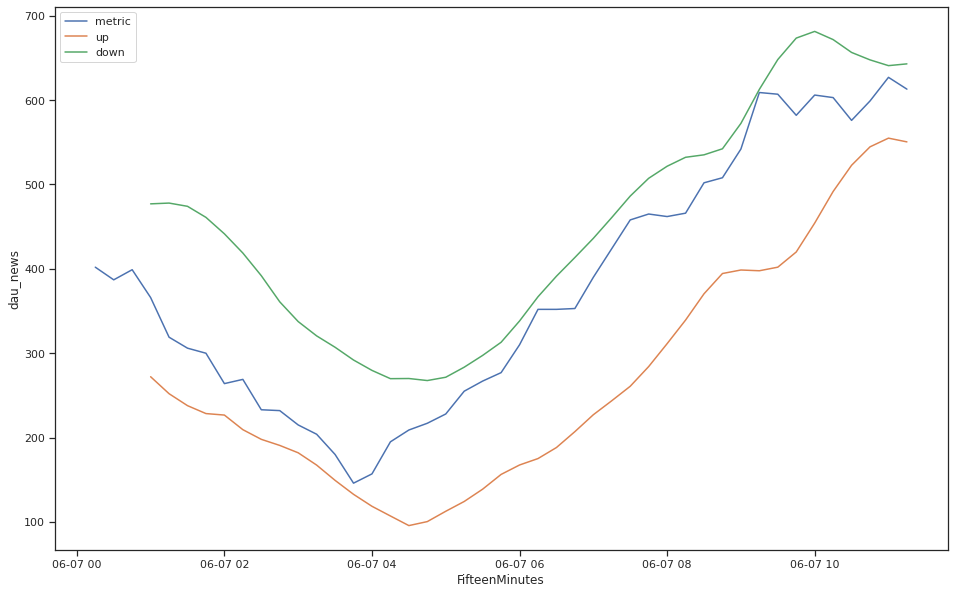

In [201]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')

def check_anomaly(df,metric, a1=3,a2=3, n=5, per = 0.1):
    mapping = {True:1, False:0}
    # день назад и неделю назад
    df['day_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=1)
    df['week_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=6)
    day_ago = df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'day_ago',metric:metric+'_day_ago'})
    week_ago= df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'week_ago',metric:metric+'_week_ago'})
    df = df.merge(day_ago,how='left', sort=False).merge(week_ago,how='left', sort=False)
    
    df['diff_d'] = round((df[metric+'_day_ago'] / df[metric]) - 1,2)
    df['diff_w'] = round((df[metric+'_week_ago'] / df[metric]) - 1,2)
    df['is_alert_d'] = (abs(df['diff_d']) > thereshold).map(mapping)
    df['is_alert_w'] = (abs(df['diff_w']) > thereshold).map(mapping) 
    
    # межквартильный размах
    df['25q'] =df[metric].shift(1).rolling(n).quantile(0.25)
    df['75q'] =df[metric].shift(1).rolling(n).quantile(0.75)
    df['IQR'] =df['75q'] - df['25q']
    df['minq'] = df['25q'] -  a1  * df['IQR']
    df['maxq'] = df['75q'] +  a1 * df['IQR']
    df['minq'] = df['minq'].rolling(n,center =True, min_periods =1).mean()
    df['maxq'] = df['maxq'].rolling(n,center =True, min_periods =1).mean()
   
    df['is_alert_q'] = ((df[metric] < df['minq']) | (df[metric] > df['maxq'])).map(mapping) 
    
    #сигмы
    df['std'] = df[metric].shift(1).rolling(n).std()
    df['mean'] = df[metric].shift(1).rolling(n).mean()
    
    df['mins'] = df['mean'] - a2 * df['std']
    df['maxs'] = df['mean'] + a2 * df['std']
    
    df['mins'] = df['mins'].rolling(n,center =True, min_periods =1).mean()
    df['maxs'] = df['maxs'].rolling(n,center =True, min_periods =1).mean() 
    
    df['is_alert_s'] = ((df[metric] < df['mins']) | (df[metric] > df['maxs'])).map(mapping) 
    
    df['is_alert_sum'] = df['is_alert_s']+df['is_alert_d']+df['is_alert_w']+df['is_alert_q']
    
    if (df['is_alert_sum'].iloc[-1] >=3):          #df[metric].iloc[-1] < df['minq'].iloc[-1]  or df[metric].iloc[-1] > df['maxq'].iloc[-1]:
        is_alert = 1
    else:
        is_alert = 0
    return is_alert, df


def run_alerts(chat=None):
    #подключаемся к телеге
    chat_id = chat or 400853280
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token)
    #выгружаем данные из базы
    data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
                ,now() as now
            from f
            --where time < toStartOfFifteenMinutes(now())
            --toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            where FifteenMinutes > today() -1 and FifteenMinutes <= '2022-06-07 11:15:00'
            order by FifteenMinutes
            '''
            ).df    
#маркеры времени для проверки
    voc = pd.DataFrame(
       [['dau_news','http://superset.lab.karpov.courses/r/1241', 'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['view','http://superset.lab.karpov.courses/r/1243',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['like','http://superset.lab.karpov.courses/r/1242',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['CTR','http://superset.lab.karpov.courses/r/1244',  'https://superset.lab.karpov.courses/superset/dashboard/988/',4,3,5,0.1], 
       ['dau_message','http://superset.lab.karpov.courses/r/1245',  'https://superset.lab.karpov.courses/superset/dashboard/988/',1.5,3,5,0.1], 
       ['count_message','http://superset.lab.karpov.courses/r/1246',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,3,7,0.1]]\
        , columns=['index','Chart_url','Dash_url','a1','a2','n','thereshold'])

    metrics_list =['dau_news','view','like','CTR','dau_message','count_message']
    for metric in metrics_list:
        df = data_from_base[['FifteenMinutes','date','hm','now',metric]].copy()
        voc_new = voc[voc['index'] == metric]
        chart = voc_new['Chart_url'].iloc[-1]
        dash = voc_new['Dash_url'].iloc[-1]
        a1 = voc_new['a1'].iloc[-1]
        a2 = voc_new['a2'].iloc[-1]        
        n = voc_new['n'].iloc[-1]
        now = data_from_base['FifteenMinutes'].max()
        #df =  df[df.date == today]
        is_alert, df = check_anomaly(df, metric,a1,a2,n)
        
        if is_alert == 1:
            msg = '''
                Показатель {metric} на {time}:
текущее значение = {current_value:.2f}
отклонение от предыдущего значения  {diff:.2%}
<a href='{chart}' >График </a> на <a href='{dash}' > дашборде </a>
@jeka_pe4enka
                '''.format(metric = metric
                            ,time = now
                           ,current_value = df[metric].iloc[-1]
                           ,diff = 1- (df[metric].iloc[-1]/df[metric].iloc[-2])
                           ,chart = chart
                           ,dash = dash
                          )
        #рисуем график
            #metric = df[0]
            plt.figure(figsize=(16, 10))
            plt.tight_layout()
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df[metric],label = 'metric')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df['mins'],label = 'up')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df['maxs'],label = 'down')
        # этот цикл нужен чтобы разрядить подписи координат по оси Х
            for ind, label in enumerate(ax.get_xticklabels()): 
                if ind % 2 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
                ax.set(xlabel='time') # задаем имя оси Х
                ax.set(ylabel=metric) # задаем имя оси У
                ax.set_title('{}'.format(metric)) # задаем заголовок графика
                ax.set(ylim=(0, None)) # задаем лимит для оси У


            # формируем файловый объект
            plot_object = io.BytesIO()
            ax.figure.savefig(plot_object)
            plot_object.seek(0)
            plot_object.name = '{0}.png'.format(metric)
            plt.close()

            # отправляем алерт
            #bot.sendMessage(chat_id=chat_id, text=msg)
            bot.sendPhoto(chat_id=chat_id, photo=plot_object, caption = msg, parse_mode ='HTML')
try:
    run_alerts()
except Exception as e:
    print(e)  


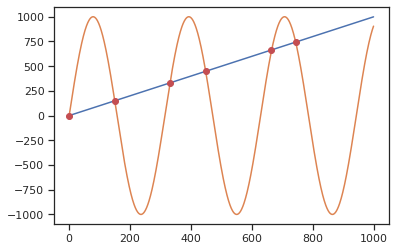

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 1000)
f = np.arange(0, 1000)
g = np.sin(np.arange(0, 10, 0.01) * 2) * 1000

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
plt.plot(x[idx], f[idx], 'ro')
plt.show()


In [203]:
voc_new = voc[voc['index'] == metric]
chart = voc_new['Chart_url'].iloc[-1]
dash = voc_new['Dash_url'].iloc[-1]
a1 = voc_new['a1'].iloc[-1]
a2 = voc_new['a2'].iloc[-1]        
n = voc_new['n'].iloc[-1]
now = data_from_base['FifteenMinutes'].max()

In [204]:
df_new = df[df.date > '2022-06-07'].reset_index()

In [205]:
df_new

,index,FifteenMinutes,date,hm,now,dau_message,day_ago,week_ago,dau_message_day_ago,dau_message_week_ago,...,IQR,minq,maxq,is_alert_q,std,mean,mins,maxs,is_alert_s,is_alert_sum
0,6912,2022-06-08 00:00:00,2022-06-08,00:00,2022-06-08 17:30:59,65,2022-06-07 00:00:00,2022-06-02 00:00:00,81.0,63.0,...,10.0,41.000000,108.200,0,19.766133,74.8,25.889705,123.230295,0,1
1,6913,2022-06-08 00:15:00,2022-06-08,00:15,2022-06-08 17:30:59,58,2022-06-07 00:15:00,2022-06-02 00:15:00,73.0,64.0,...,6.0,49.100000,91.500,0,8.203658,66.4,32.234712,108.805288,0,1
2,6914,2022-06-08 00:30:00,2022-06-08,00:30,2022-06-08 17:30:59,70,2022-06-07 00:30:00,2022-06-02 00:30:00,58.0,79.0,...,8.0,53.900000,80.300,0,8.438009,63.8,38.861998,96.178002,0,2
3,6915,2022-06-08 00:45:00,2022-06-08,00:45,2022-06-08 17:30:59,69,2022-06-07 00:45:00,2022-06-02 00:45:00,63.0,73.0,...,5.0,55.500000,77.100,0,6.633250,67.0,46.048305,85.311695,0,0
4,6916,2022-06-08 01:00:00,2022-06-08,01:00,2022-06-08 17:30:59,66,2022-06-07 01:00:00,2022-06-02 01:00:00,65.0,74.0,...,4.0,56.600000,75.800,0,4.722288,65.6,48.044450,83.155550,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,6977,2022-06-08 16:15:00,2022-06-08,16:15,2022-06-08 17:30:59,151,2022-06-07 16:15:00,2022-06-02 16:15:00,143.0,134.0,...,10.0,121.100000,166.700,0,16.890826,149.4,107.709322,185.650678,0,1
66,6978,2022-06-08 16:30:00,2022-06-08,16:30,2022-06-08 17:30:59,143,2022-06-07 16:30:00,2022-06-02 16:30:00,142.0,146.0,...,9.0,126.500000,165.700,0,12.557866,153.8,108.753751,189.806249,0,0
67,6979,2022-06-08 16:45:00,2022-06-08,16:45,2022-06-08 17:30:59,144,2022-06-07 16:45:00,2022-06-02 16:45:00,142.0,139.0,...,7.0,131.700000,164.500,0,13.446189,151.6,108.744269,193.895731,0,0
68,6980,2022-06-08 17:00:00,2022-06-08,17:00,2022-06-08 17:30:59,138,2022-06-07 17:00:00,2022-06-02 17:00:00,124.0,151.0,...,7.0,132.375000,163.375,0,13.446189,151.6,111.248456,192.351544,0,0


[(0.0, 655.2438209015017)]

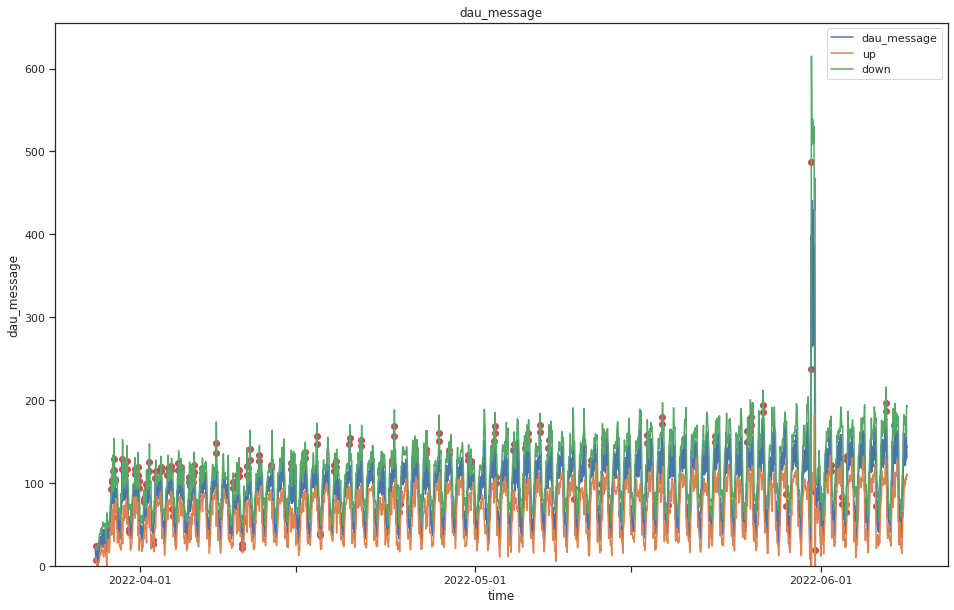

In [244]:
plt.figure(figsize=(16, 10))
plt.tight_layout()
x = df['FifteenMinutes']
y1 = df[metric]
y2 = df['mins']
y3 = df['maxs']

#plt.plot(x, y1)
#plt.plot(x, y2)
#plt.plot(x, y3)


idx1 = np.argwhere(np.diff(np.sign(y3 - y1))).flatten()+1
idx2 = np.argwhere(np.diff(np.sign(y1 - y2))).flatten()+1

plt.plot(x[idx1],y3[idx1], 'ro')
plt.plot(x[idx2],y2[idx2], 'ro')

ax = sns.lineplot(x=df['FifteenMinutes'], y=df[metric],label = metric)
ax = sns.lineplot(x=df['FifteenMinutes'], y=df['mins'],label = 'up')
ax = sns.lineplot(x=df['FifteenMinutes'], y=df['maxs'],label = 'down')



for ind, label in enumerate(ax.get_xticklabels()): 
    if ind % 2 == 0:
            label.set_visible(True)
    else:
            label.set_visible(False)
ax.set(xlabel='time') # задаем имя оси Х
ax.set(ylabel= metric) # задаем имя оси У
ax.set_title('{}'.format(metric)) # задаем заголовок графика
ax.set(ylim=(0, None)) # задаем лимит для оси У

In [242]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')

def check_anomaly(df,metric, a1=3,a2=3, n=5, per = 0.1):
    mapping = {True:1, False:0}
    # день назад и неделю назад
    df['day_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=1)
    df['week_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=6)
    day_ago = df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'day_ago',metric:metric+'_day_ago'})
    week_ago= df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'week_ago',metric:metric+'_week_ago'})
    df = df.merge(day_ago,how='left', sort=False).merge(week_ago,how='left', sort=False)
    
    df['diff_d'] = round((df[metric+'_day_ago'] / df[metric]) - 1,2)
    df['diff_w'] = round((df[metric+'_week_ago'] / df[metric]) - 1,2)
    df['is_alert_d'] = (abs(df['diff_d']) > thereshold).map(mapping)
    df['is_alert_w'] = (abs(df['diff_w']) > thereshold).map(mapping)     
    
    # межквартильный размах
    df['25q'] =df[metric].shift(1).rolling(n).quantile(0.25)
    df['75q'] =df[metric].shift(1).rolling(n).quantile(0.75)
    df['IQR'] =df['75q'] - df['25q']
    df['minq'] = df['25q'] -  a1  * df['IQR']
    df['maxq'] = df['75q'] +  a1 * df['IQR']
    df['minq'] = df['minq'].rolling(n,center =True, min_periods =1).mean()
    df['maxq'] = df['maxq'].rolling(n,center =True, min_periods =1).mean()
   
    df['is_alert_q'] = ((df[metric] < df['minq']) | (df[metric] > df['maxq'])).map(mapping) 
    
    #сигмы
    df['std'] = df[metric].shift(1).rolling(n).std()
    df['mean'] = df[metric].shift(1).rolling(n).mean()
    
    df['mins'] = df['mean'] - a2 * df['std']
    df['maxs'] = df['mean'] + a2 * df['std']
    
    df['mins'] = df['mins'].rolling(n,center =True, min_periods =1).mean()
    df['maxs'] = df['maxs'].rolling(n,center =True, min_periods =1).mean() 
    
    df['is_alert_s'] = ((df[metric] < df['mins']) | (df[metric] > df['maxs'])).map(mapping) 
    
    df['is_alert_sum'] = df['is_alert_s']+df['is_alert_d']+df['is_alert_w']+df['is_alert_q']
    
    if (df['is_alert_sum'].iloc[-1] >=3):          #df[metric].iloc[-1] < df['minq'].iloc[-1]  or df[metric].iloc[-1] > df['maxq'].iloc[-1]:
        is_alert = 1
    else:
        is_alert = 0
    return is_alert, df


def run_alerts(chat=None):
    #подключаемся к телеге
    chat_id = chat or 400853280
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token)
    #выгружаем данные из базы
    data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
                ,now() as now
            from f
            --where time < toStartOfFifteenMinutes(now())
            --toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            where FifteenMinutes > today() -1 --and FifteenMinutes <= '2022-06-07 11:15:00'
            order by FifteenMinutes
            '''
            ).df    
#маркеры времени для проверки
    voc = pd.DataFrame(
       [['dau_news','http://superset.lab.karpov.courses/r/1241', 'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['view','http://superset.lab.karpov.courses/r/1243',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['like','http://superset.lab.karpov.courses/r/1242',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['CTR','http://superset.lab.karpov.courses/r/1244',  'https://superset.lab.karpov.courses/superset/dashboard/988/',4,3,5,0.1], 
       ['dau_message','http://superset.lab.karpov.courses/r/1245',  'https://superset.lab.karpov.courses/superset/dashboard/988/',1.5,3,5,0.1], 
       ['count_message','http://superset.lab.karpov.courses/r/1246',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,3,7,0.1]]\
        , columns=['index','Chart_url','Dash_url','a1','a2','n','thereshold'])

    metrics_list =['dau_news','view','like','CTR','dau_message','count_message']
    for metric in metrics_list:
        df = data_from_base[['FifteenMinutes','date','hm','now',metric]].copy()
        voc_new = voc[voc['index'] == metric]
        chart = voc_new['Chart_url'].iloc[-1]
        dash = voc_new['Dash_url'].iloc[-1]
        a1 = voc_new['a1'].iloc[-1]
        a2 = voc_new['a2'].iloc[-1]        
        n = voc_new['n'].iloc[-1]
        thereshold = voc_new['thereshold'].iloc[-1]
        now = data_from_base['FifteenMinutes'].max()
        #df =  df[df.date == today]
        is_alert, df = check_anomaly(df, metric,a1,a2,n, thereshold)
        
        if is_alert == 1 or True:
            msg = '''
                Показатель {metric} на {time}:
текущее значение = {current_value:.2f}
отклонение от предыдущего значения  {diff:.2%}
<a href='{chart}' >график </a> - <a href='{dash}' >дашборд </a>
@jeka_pe4enka
                '''.format(metric = metric
                            ,time = now
                           ,current_value = df[metric].iloc[-1]
                           ,diff = 1- (df[metric].iloc[-1]/df[metric].iloc[-2])
                           ,chart = chart
                           ,dash = dash
                          )
        #рисуем график
            #metric = df[0]
            plt.figure(figsize=(16, 10))
            plt.tight_layout()
            x = df['FifteenMinutes']
            y1 = df[metric]
            y2 = df['mins']
            y3 = df['maxs']

            #plt.plot(x, y1)
            #plt.plot(x, y2)
            #plt.plot(x, y3)


            idx1 = np.argwhere(np.diff(np.sign(y3 - y1))).flatten()+1
            idx2 = np.argwhere(np.diff(np.sign(y2 - y1))).flatten()+1

            plt.plot(x[idx1],y3[idx1], 'ro')
            plt.plot(x[idx2],y2[idx2], 'ro')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df[metric],label = 'metric')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df['minq'],label = 'up')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df['maxq'],label = 'down')
        # этот цикл нужен чтобы разрядить подписи координат по оси Х
            for ind, label in enumerate(ax.get_xticklabels()): 
                if ind % 2 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
                ax.set(xlabel='time') # задаем имя оси Х
                ax.set(ylabel=metric) # задаем имя оси У
                ax.set_title('{}'.format(metric)) # задаем заголовок графика
                ax.set(ylim=(0, None)) # задаем лимит для оси У


            # формируем файловый объект
            plot_object = io.BytesIO()
            ax.figure.savefig(plot_object)
            plot_object.seek(0)
            plot_object.name = '{0}.png'.format(metric)
            plt.close()

            # отправляем алерт
            #bot.sendMessage(chat_id=chat_id, text=msg)
            bot.sendPhoto(chat_id=chat_id, photo=plot_object, caption = msg, parse_mode ='HTML')
try:
    run_alerts()
except Exception as e:
    print(e) 
